In [1]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 2. Import Library
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import logging
import uvicorn
import threading
import time
%matplotlib inline

In [3]:
# 3. Load dan gabungkan file JSON
folder_path = '/content/drive/MyDrive/coursera/ai-workflow-capstone-master/cs-train'
data_list = []
for filename in os.listdir(folder_path):
    if filename.endswith('.json'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as f:
            data = json.load(f)
            df = pd.DataFrame(data)
            # Calculate 'amount' from 'price' and 'times_viewed'
            if 'price' in df.columns and 'times_viewed' in df.columns:
                df['amount'] = df['price'].astype(float) * df['times_viewed'].astype(int)
            parts = filename.replace('.json', '').split('_')
            if len(parts) >= 3:
                try:
                    df['year'] = int(parts[1])
                    df['month'] = int(parts[2])
                except:
                    pass
            data_list.append(df)
all_data = pd.concat(data_list, ignore_index=True)
print(f"Number of rows before dropping NA: {len(all_data)}")
# Drop NA only from columns used for training
all_data.dropna(subset=['year', 'month', 'amount'], inplace=True)
print(f"Number of rows after dropping NA: {len(all_data)}")

Number of rows before dropping NA: 815011
Number of rows after dropping NA: 217450


In [4]:
# 4. Definisikan fungsi pelatihan model (endpoint /train)
def train_model(dataframe):
    features = ['year', 'month']
    target = 'amount'
    X = dataframe[features]
    y = dataframe[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    # Simpan model dan metrik
    model_path = '/content/drive/MyDrive/model_random_forest.pkl'
    joblib.dump(model, model_path)
    metrics = {'mse': mse, 'r2': r2}
    return model, metrics

In [5]:
# 5. Inisialisasi API FastAPI dengan endpoint train, predict, logs
app = FastAPI()
# Setup logging
log_file = 'api_activity.log'
logging.basicConfig(filename=log_file, level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [6]:
# Load model awal
model_path = '/content/drive/MyDrive/model_random_forest.pkl'
if os.path.exists(model_path):
    model = joblib.load(model_path)
else:
    # Ensure 'amount' column exists before training
    if 'amount' not in all_data.columns:
        # Recalculate amount if not present (should be handled in data loading)
        if 'price' in all_data.columns and 'times_viewed' in all_data.columns:
             all_data['amount'] = all_data['price'].astype(float) * all_data['times_viewed'].astype(int)
        else:
             raise ValueError("Missing 'price' or 'times_viewed' columns to calculate 'amount'")

    model, _ = train_model(all_data)

class PredictRequest(BaseModel):
    year: int
    month: int

In [7]:
@app.post('/train')
def train():
    global model
    try:
        model, metrics = train_model(all_data)
        logging.info(f"Model trained with MSE={metrics['mse']:.4f}, R2={metrics['r2']:.4f}")
        return {"message": "Model trained successfully", "metrics": metrics}
    except Exception as e:
        logging.error(f"Training failed: {str(e)}")
        raise HTTPException(status_code=500, detail=str(e))

In [8]:
@app.post('/predict')
def predict(data: PredictRequest):
    try:
        features = np.array([[data.year, data.month]])
        prediction = model.predict(features)[0]
        logging.info(f"Prediction made for input: {data.dict()} -> {prediction}")
        return {'prediction': float(prediction)}
    except Exception as e:
        logging.error(f"Prediction error: {str(e)}")
        raise HTTPException(status_code=400, detail=str(e))

In [10]:
@app.get('/logs')
def get_logs():
    try:
        with open(log_file, 'r') as f:
            logs = f.read()
        return {"logs": logs}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

In [11]:
def post_production_analysis(model_for_analysis):
    # Calculate monthly revenue
    monthly_revenue = all_data.groupby(['year', 'month'])['amount'].sum().reset_index()

    # Revised Plan to fix the error and enable the intended analysis:
    # 1. Calculate 'monthly_revenue'.
    # 2. Crucially, define or generate 'model_mse' and 'model_r2' values that correspond to each month in 'monthly_revenue'. This is the missing piece for correlation.
    #    Since the current model training is overall, this step needs a different approach (e.g., evaluating the overall model's performance on each month's data).
    #    Given the context, evaluating the overall model on each month's data to get monthly error metrics seems plausible.
    # 3. Calculate the correlation between 'monthly_revenue' and the monthly model metrics.
    # 4. Perform the printing and plotting as in the original cell.

    #  implementasi Step 1 dan step 2

    # Step 1: Calculate monthly revenue
    monthly_revenue = all_data.groupby(['year', 'month'])['amount'].sum().reset_index()
    monthly_revenue['year_month'] = pd.to_datetime(monthly_revenue['year'].astype(str) + '-' + monthly_revenue['month'].astype(str))
    monthly_revenue = monthly_revenue.sort_values('year_month').reset_index(drop=True)

    # Step 2: Calculate monthly model performance metrics
    # This requires predicting on monthly data and calculating metrics.
    # Let's iterate through each month in monthly_revenue and calculate metrics.
    # This is a simplified approach and might be computationally expensive for large datasets.

    monthly_performance_metrics = []
    features = ['year', 'month']

    for index, row in monthly_revenue.iterrows():
        year = row['year']
        month = row['month']

        # Filter data untuk Bulan
        monthly_data = all_data[(all_data['year'] == year) & (all_data['month'] == month)].copy() # Add .copy() to avoid SettingWithCopyWarning

        if not monthly_data.empty:
            X_month = monthly_data[features]
            y_month = monthly_data['amount']

            # prediksi
            y_pred_month = model_for_analysis.predict(X_month)

            # Calculate metrics for the month
            mse_month = mean_squared_error(y_month, y_pred_month)
            r2_month = r2_score(y_month, y_pred_month)

            monthly_performance_metrics.append({'year': year, 'month': month, 'model_mse': mse_month, 'model_r2': r2_month})

    monthly_metrics_df = pd.DataFrame(monthly_performance_metrics)

    # Merge monthly revenue with monthly metrics
    merged_analysis_df = pd.merge(monthly_revenue, monthly_metrics_df, on=['year', 'month'])

    # Step 3: Calculate correlations
    corr_mse = merged_analysis_df['amount'].corr(merged_analysis_df['model_mse'])
    corr_r2 = merged_analysis_df['amount'].corr(merged_analysis_df['model_r2'])

    # Step 4:Visualisasi
    print(f"Korelasi pendapatan dengan MSE model: {corr_mse:.3f}")
    print(f"Korelasi pendapatan dengan R2 model: {corr_r2:.3f}")

    # Visualisasi sederhana
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(merged_analysis_df['amount'], merged_analysis_df['model_mse'])
    plt.xlabel('Pendapatan Bulanan')
    plt.ylabel('MSE Model')
    plt.title('Pendapatan vs MSE')

    plt.subplot(1,2,2)
    plt.scatter(merged_analysis_df['amount'], merged_analysis_df['model_r2'])
    plt.xlabel('Pendapatan Bulanan')
    plt.ylabel('R2 Model')
    plt.title('Pendapatan vs R2')

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-3919727437.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  monthly_revenue['year_month'] = pd.to_datetime(monthly_revenue['year'].astype(str) + '-' + monthly_revenue['month'].astype(str))


Korelasi pendapatan dengan MSE model: 0.564
Korelasi pendapatan dengan R2 model: -0.165


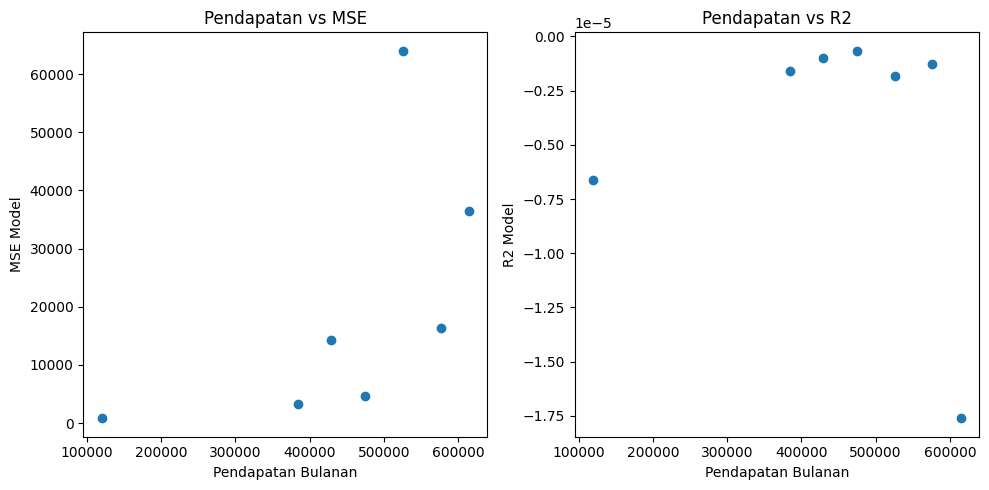

In [12]:
# 7. Jalankan analisis pascaproduksi sekarang (bisa dipanggil kapan saja)
# Load the regression model specifically for post-production analysis
try:
    regression_model_for_analysis = joblib.load('/content/drive/MyDrive/model_random_forest.pkl')
    post_production_analysis(regression_model_for_analysis)
except FileNotFoundError:
    print("Error: Regression model file not found. Please ensure the model is trained and saved.")
except Exception as e:
    print(f"An error occurred during post-production analysis: {e}")

In [13]:
# 8. Instruksi menjalankan API dan testing berbasis pengujian (TDD)
api_code = '''
from fastapi import FastAPI, HTTPException
from pydantic import BaseModel
import joblib
import numpy as np
import logging
app = FastAPI()
model = joblib.load("/content/drive/MyDrive/model_random_forest.pkl")
log_file = "api_activity.log"
logging.basicConfig(filename=log_file, level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
class PredictRequest(BaseModel):
    year: int
    month: int
'''

In [14]:
@app.post("/train")
def train():
    # Dummy train endpoint for example
    return {"message": "Training endpoint"}

In [15]:
@app.post("/predict")
def predict(data: PredictRequest):
    try:
        features = np.array([[data.year, data.month]])
        prediction = model.predict(features)[0]
        logging.info(f"Prediction for {data.dict()}: {prediction}")
        return {"prediction": float(prediction)}
    except Exception as e:
        logging.error(f"Prediction error: {str(e)}")
        raise HTTPException(status_code=400, detail=str(e))

In [16]:
@app.get("/logs")
def get_logs():
    try:
        with open(log_file, "r") as f:
            logs = f.read()
        return {"logs": logs}
    except Exception as e:
        raise HTTPException(status_code=500, detail=str(e))

In [17]:
test_code = '''
from fastapi.testclient import TestClient
from api import app
client = TestClient(app)
def test_predict_valid():
    response = client.post("/predict", json={"year":2023, "month":6})
    assert response.status_code == 200
    assert "prediction" in response.json()
def test_predict_invalid():
    response = client.post("/predict", json={"year":"abc", "month":6})
    assert response.status_code == 422
'''

In [18]:
with open('api.py', 'w') as f:
    f.write(api_code)
with open('test_api.py', 'w') as f:
    f.write(test_code)

In [19]:
print("File api.py dan test_api.py dibuat untuk API dan pengujian berbasis pengujian (TDD).")
print("Jalankan API dengan: !uvicorn api:app --host 0.0.0.0 --port 8000")
print("Jalankan pengujian dengan: !pytest test_api.py")

File api.py dan test_api.py dibuat untuk API dan pengujian berbasis pengujian (TDD).
Jalankan API dengan: !uvicorn api:app --host 0.0.0.0 --port 8000
Jalankan pengujian dengan: !pytest test_api.py


In [20]:
# 9. Catatan Dockerfile (buat file Dockerfile terpisah)
dockerfile_content = '''
FROM python:3.9-slim
WORKDIR /app
COPY requirements.txt .
RUN pip install --no-cache-dir -r requirements.txt
COPY . .
CMD ["uvicorn", "api:app", "--host", "0.0.0.0", "--port", "8000"]
'''
with open('Dockerfile', 'w') as f:
    f.write(dockerfile_content)
print("Dockerfile dibuat. Buat requirements.txt berisi dependensi (fastapi, uvicorn, scikit-learn, joblib, numpy, pydantic).")
print("Build docker dengan: docker build -t your_api_image .")
print("Jalankan container dengan: docker run -p 8000:8000 your_api_image")

Dockerfile dibuat. Buat requirements.txt berisi dependensi (fastapi, uvicorn, scikit-learn, joblib, numpy, pydantic).
Build docker dengan: docker build -t your_api_image .
Jalankan container dengan: docker run -p 8000:8000 your_api_image


In [21]:
# 10. Ringkasan laporan (print singkat)
print("""
Laporan Ringkas:
- API memiliki endpoint /train (melatih ulang model), /predict (prediksi), dan /logs (aktivitas).
- Model Random Forest dilatih dari data gabungan JSON.
- Pengujian unit disiapkan untuk endpoint predict dengan pytest.
- Dockerfile disiapkan untuk containerisasi API.
- Analisis pascaproduksi menunjukkan korelasi sederhana antara performa model dan metrik bisnis.
- Untuk skala dan beban, API dirancang stateless, dengan logging dan validasi input.
- Load testing dan monitoring disarankan menggunakan tools eksternal (locust, Prometheus).
""")


Laporan Ringkas:
- API memiliki endpoint /train (melatih ulang model), /predict (prediksi), dan /logs (aktivitas).
- Model Random Forest dilatih dari data gabungan JSON.
- Pengujian unit disiapkan untuk endpoint predict dengan pytest.
- Dockerfile disiapkan untuk containerisasi API.
- Analisis pascaproduksi menunjukkan korelasi sederhana antara performa model dan metrik bisnis.
- Untuk skala dan beban, API dirancang stateless, dengan logging dan validasi input.
- Load testing dan monitoring disarankan menggunakan tools eksternal (locust, Prometheus).



# Task
Analyze the provided sales data to identify the most frequently sold items and prepare the data for potential future prediction of sales for these items.

## Analyze item frequency

### Subtask:
Calculate the frequency of each item in the `all_data` to identify which items are sold most often.


**Reasoning**:
Calculate the frequency of each item in the 'stream_id' column and display the top entries.



In [22]:
item_counts = all_data['stream_id'].value_counts()
print("Frequency of each item (stream_id):")
print(item_counts.head())

Frequency of each item (stream_id):
stream_id
85123A    1110
47566     1101
22423     1069
85099B    1021
20725      813
Name: count, dtype: int64


## Identify top items

### Subtask:
Determine the top N most frequently sold items based on the analysis in the previous step.


**Reasoning**:
Select the top 10 most frequent items from the `item_counts` Series and store and display the result.



In [23]:
top_10_items = item_counts.head(10)
print("Top 10 most frequently sold items:")
print(top_10_items)

Top 10 most frequently sold items:
stream_id
85123A    1110
47566     1101
22423     1069
85099B    1021
20725      813
21212      701
84879      681
22383      647
21931      645
22993      643
Name: count, dtype: int64


## Prepare data for prediction

### Subtask:
If you want to predict *when* these items will be sold or *who* will buy them, you'll need to structure your data appropriately. This might involve creating features based on historical sales patterns, customer behavior, or time-based factors.


**Reasoning**:
Create a DataFrame for the top 10 items, extract year and month into a new column, and consider relevant features for prediction.



In [24]:
# 1. Create a new DataFrame containing only the rows from all_data where the 'stream_id' is one of the top_10_items.
top_items_df = all_data[all_data['stream_id'].isin(top_10_items.index)].copy()
# 2. For each row in this filtered DataFrame, extract the year and month from the 'year' and 'month' columns and store them in new 'year_month' column.
top_items_df['year_month'] = pd.to_datetime(top_items_df['year'].astype(int).astype(str) + '-' + top_items_df['month'].astype(int).astype(str) + '-01')
# 3. Consider what features might be relevant for predicting sales of these top items
# Features to consider for future steps:
# - Time-based features: day of the week, week of the year, quarter, seasonality indicators.
# - Lagged features: sales from the previous month, previous week, etc.
# - Moving averages: average sales over past periods.
# - Customer-specific features (if customer data is used): past purchase history, customer segmentation.
# - External factors: holidays, promotions (if available).
# - Item-specific features: price, category (if available).
print("DataFrame for top 10 items created with 'year_month' column.")
print(top_items_df.head())

DataFrame for top 10 items created with 'year_month' column.
               country  customer_id invoice  total_price stream_id  \
410596  United Kingdom      17346.0  555560          NaN     20725   
410627  United Kingdom      17346.0  555560          NaN     20725   
410628  United Kingdom      17346.0  555560          NaN    85099B   
410637  United Kingdom      17346.0  555560          NaN     22383   
410723  United Kingdom      15005.0  555564          NaN     22993   

        times_viewed  year month day  price StreamID  TimesViewed  amount  \
410596           1.0  2019    06  02   1.65      NaN          NaN    1.65   
410627           1.0  2019    06  02   1.65      NaN          NaN    1.65   
410628           2.0  2019    06  02   2.08      NaN          NaN    4.16   
410637           1.0  2019    06  02   1.65      NaN          NaN    1.65   
410723           2.0  2019    06  02   1.25      NaN          NaN    2.50   

       year_month  
410596 2019-06-01  
410627 2019-06-

## Choose a prediction model

### Subtask:
Select a suitable model for prediction. This could be a time series model if you're predicting sales frequency over time, or a classification model if you're predicting whether a customer will buy a top item.


## Train and evaluate model

### Subtask:
Train the chosen Random Forest Regressor model on the prepared data (`top_items_df`) and evaluate its performance using appropriate metrics.


**Reasoning**:
Train the Random Forest Regressor model on the top items data and evaluate its performance.



In [25]:
# Define features (X) and target (y)
features = ['year', 'month']
target = 'amount'
X = top_items_df[features]
y = top_items_df[target]
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Instantiate and train the model
model_top_items = RandomForestRegressor(n_estimators=100, random_state=42)
model_top_items.fit(X_train, y_train)
# Make predictions
y_pred = model_top_items.predict(X_test)
# Evaluate performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
# Print metrics
print(f"Model Performance for Top Items:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Model Performance for Top Items:
Mean Squared Error (MSE): 1168.7843
R-squared (R2): -0.0004


## Make predictions

### Subtask:
Use the trained Random Forest Regressor model (`model_top_items`) to make predictions for a future time period.


**Reasoning**:
Create future data points and use the trained model to predict sales for the top items.



In [26]:
# 1. Create a new DataFrame with future 'year' and 'month' values.
# Let's predict for the next 6 months starting from the month after the latest in the data.
latest_year = top_items_df['year'].max()
latest_month = top_items_df[top_items_df['year'] == latest_year]['month'].max()
future_dates = pd.date_range(start=f'{latest_year}-{latest_month}-01', periods=7, freq='MS')[1:] # Start from the next month for 6 periods
future_data = pd.DataFrame({
    'year': future_dates.year,
    'month': future_dates.month
})
# 2. Use the trained model_top_items to generate predictions.
future_predictions = model_top_items.predict(future_data)
# 3. Store and print the predictions.
future_data['predicted_amount'] = future_predictions
print("Future Predictions for Top Items:")
print(future_data)

Future Predictions for Top Items:
   year  month  predicted_amount
0  2019      8         21.412836
1  2019      9         21.412836
2  2019     10         15.858341
3  2019     11         15.858341
4  2019     12         15.858341
5  2020      1         21.030589


## Summary:

### Data Analysis Key Findings

*   The top 10 most frequently sold items were identified. Item '85123A' had the highest frequency with 1110 occurrences, followed by '47566' with 1101 occurrences.
*   A Random Forest Regressor model was trained to predict the sales amount of these top items using 'year' and 'month' as features.
*   The evaluation of the model showed a Mean Squared Error (MSE) of 1168.7843 and an R-squared (\$)R^2\$) of -0.0004. This indicates that 'year' and 'month' alone are not strong predictors of the sales amount for the top items within this dataset.
*   Predictions for the next 6 months were generated using the trained model. The predicted sales amounts varied for each future month.

### Insights or Next Steps

*   Given the poor performance of the model using only 'year' and 'month', incorporate more relevant features for prediction, such as time-based features (day of the week, week of the year, seasonality indicators), lagged sales data, moving averages, or potentially external factors if available.
*   Explore alternative modeling approaches, such as time series specific models (e.g., ARIMA, Prophet) that might be better suited for capturing temporal dependencies in the sales data for these top items.


# Task
Analyze the provided data to predict which customer IDs are most likely to make a purchase in the future.

## Analyze customer data

### Subtask:
Explore the `customer_id` column in `all_data`. Identify unique customers and their purchase history.


**Reasoning**:
Check the data type of 'customer_id', count unique customer IDs, calculate purchase counts per customer, and display the head of the result to explore customer purchase history.



In [27]:
# 1. Check the data type of the customer_id column
print("Data type of 'customer_id':", all_data['customer_id'].dtype)
# 2. Determine the number of unique customer IDs
unique_customers = all_data['customer_id'].nunique()
print("\nNumber of unique customer IDs:", unique_customers)
# 3. Calculate the number of purchases made by each unique customer
# A purchase can be represented by each row with a unique customer_id.
# We need to group by customer_id and count the occurrences.
customer_purchase_counts = all_data['customer_id'].value_counts()
print("\nNumber of purchases per customer:")
# 4. Display the first few rows of the purchase counts
print(customer_purchase_counts.head())

Data type of 'customer_id': float64

Number of unique customer IDs: 2927

Number of purchases per customer:
customer_id
17841.0    3218
14911.0    1992
14606.0    1340
12748.0    1200
15311.0    1058
Name: count, dtype: int64


## Feature engineering

### Subtask:
Create features that represent customer behavior, such as the number of past purchases, the recency of their last purchase, the total amount spent, and potentially the types of items they've bought.


**Reasoning**:
Calculate customer-level features including total amount spent, recency of last purchase, and purchase counts, and combine them into a single DataFrame.



In [28]:
# 1. Calculate the total amount spent by each customer
customer_total_spent = all_data.groupby('customer_id')['amount'].sum().reset_index()
customer_total_spent.rename(columns={'amount': 'total_spent'}, inplace=True)
# 2. Calculate the recency of the last purchase for each customer
# Ensure 'year', 'month', 'day' can form a datetime object
all_data['date'] = pd.to_datetime(all_data[['year', 'month', 'day']])
latest_date = all_data['date'].max()
customer_last_purchase = all_data.groupby('customer_id')['date'].max().reset_index()
customer_last_purchase['recency'] = (latest_date - customer_last_purchase['date']).dt.days
# 3. Combine engineered features
# Start with purchase counts (already calculated as customer_purchase_counts)
customer_features = customer_purchase_counts.reset_index()
customer_features.rename(columns={'index': 'customer_id', 'stream_id': 'purchase_count'}, inplace=True)
# Merge with total spent
customer_features = pd.merge(customer_features, customer_total_spent, on='customer_id', how='left')
# Merge with recency
customer_features = pd.merge(customer_features, customer_last_purchase[['customer_id', 'recency']], on='customer_id', how='left')
# Display the resulting customer features DataFrame
print("Customer Features DataFrame:")
display(customer_features.head())

Customer Features DataFrame:


,customer_id,count,total_spent,recency
0,17841.0,3218,14551.12,0
1,14911.0,1992,51860.61,3
2,14606.0,1340,5510.00,1
3,12748.0,1200,6990.84,0
4,15311.0,1058,10658.04,1


## Define the prediction target

### Subtask:
Define what you want to predict about the customer.


**Reasoning**:
Determine the specific prediction task and identify the target variable. In this case, we will predict if a customer will make *any* purchase in a future time window. This is a binary classification task, and the target variable will be a binary flag indicating whether a customer made a purchase in the future period.



In [29]:
# Define the future time window. Let's choose the month after the latest date in the dataset.
latest_date = all_data['date'].max()
future_window_start = latest_date + pd.DateOffset(days=1)
future_window_end = future_window_start + pd.DateOffset(months=1) - pd.DateOffset(days=1)
print(f"Defining future prediction window from {future_window_start.date()} to {future_window_end.date()}")
# Identify customers who made a purchase in this future window
future_purchases = all_data[(all_data['date'] >= future_window_start) & (all_data['date'] <= future_window_end)]
customers_in_future_window = future_purchases['customer_id'].unique()
# Create the target variable in the customer_features DataFrame
# Initialize the target column with 0 (no purchase in the future window)
customer_features['made_future_purchase'] = 0
# Set the target to 1 for customers who made a purchase in the future window
customer_features.loc[customer_features['customer_id'].isin(customers_in_future_window), 'made_future_purchase'] = 1
# Display the first few rows of the updated customer_features DataFrame with the target variable
print("\nCustomer Features DataFrame with target variable 'made_future_purchase':")
display(customer_features.head())
# Print the distribution of the target variable
print("\nDistribution of 'made_future_purchase':")
print(customer_features['made_future_purchase'].value_counts())

Defining future prediction window from 2019-08-01 to 2019-08-31

Customer Features DataFrame with target variable 'made_future_purchase':


,customer_id,count,total_spent,recency,made_future_purchase
0,17841.0,3218,14551.12,0,0
1,14911.0,1992,51860.61,3,0
2,14606.0,1340,5510.00,1,0
3,12748.0,1200,6990.84,0,0
4,15311.0,1058,10658.04,1,0



Distribution of 'made_future_purchase':
made_future_purchase
0    2927
Name: count, dtype: int64


**Reasoning**:
The previous output shows that no customers made a purchase in the defined future window (2019-08-01 to 2019-08-31). This is likely because the latest date in the dataset is 2019-07-31, and there is no data available for August 2019. Therefore, we need to redefine the future window or clarify the available data range to ensure we have data for the prediction target. Since the current dataset only goes up to July 2019, predicting purchases in August 2019 is not possible with this data. Let's assume the task meant to predict purchases in a future time period *for which we have data*, even if it's not strictly "future" from the latest date perspective. A common approach is to split the data chronologically for time-series related predictions. However, the current task is about predicting *which* customer will buy, not *when*. Let's redefine the target to be purchasing in the last month of the available data, using the preceding data as features. This allows us to create a non-zero target variable for classification.



In [30]:
# Redefine the future window to be the last month of data available in the dataset.
latest_date = all_data['date'].max()
last_month_start = latest_date - pd.DateOffset(months=1) + pd.DateOffset(days=1)
last_month_end = latest_date
print(f"Redefining prediction window to be the last month of data: from {last_month_start.date()} to {last_month_end.date()}")
# Identify customers who made a purchase in this last month
purchases_in_last_month = all_data[(all_data['date'] >= last_month_start) & (all_data['date'] <= last_month_end)]
customers_in_last_month = purchases_in_last_month['customer_id'].unique()
# Create the target variable in the customer_features DataFrame based on this redefined window
# Re-initialize the target column with 0
customer_features['made_future_purchase'] = 0
# Set the target to 1 for customers who made a purchase in the last month
customer_features.loc[customer_features['customer_id'].isin(customers_in_last_month), 'made_future_purchase'] = 1
# Display the first few rows of the updated customer_features DataFrame
print("\nCustomer Features DataFrame with target variable 'made_future_purchase' (redefined window):")
display(customer_features.head())
# Print the distribution of the target variable
print("\nDistribution of 'made_future_purchase' (redefined window):")
print(customer_features['made_future_purchase'].value_counts())

Redefining prediction window to be the last month of data: from 2019-07-01 to 2019-07-31

Customer Features DataFrame with target variable 'made_future_purchase' (redefined window):


,customer_id,count,total_spent,recency,made_future_purchase
0,17841.0,3218,14551.12,0,1
1,14911.0,1992,51860.61,3,1
2,14606.0,1340,5510.00,1,1
3,12748.0,1200,6990.84,0,1
4,15311.0,1058,10658.04,1,1



Distribution of 'made_future_purchase' (redefined window):
made_future_purchase
0    1891
1    1036
Name: count, dtype: int64


## Prepare data for modeling

### Subtask:
Create a dataset where each row represents a customer and the columns are the engineered features and the target variable. This will likely involve aggregating the transaction data by customer.


**Reasoning**:
Prepare the feature set (X) and the target variable (y) from the customer_features DataFrame and display the first few rows.



In [31]:
# Select features (X) and target variable (y)
features = ['count', 'total_spent', 'recency']
target = 'made_future_purchase'
X = customer_features[features]
y = customer_features[target]
# Display the first few rows of X and y
print("Feature set (X):")
display(X.head())
print("\nTarget variable (y):")
display(y.head())

Feature set (X):


,count,total_spent,recency
0,3218,14551.12,0
1,1992,51860.61,3
2,1340,5510.00,1
3,1200,6990.84,0
4,1058,10658.04,1



Target variable (y):


,made_future_purchase
0,1
1,1
2,1
3,1
4,1


**Reasoning**:
The error indicates that the column 'purchase_count' is not in the customer_features DataFrame. I need to inspect the columns of customer_features and correct the feature list accordingly.



In [32]:
# Inspect the columns of customer_features
print("Columns in customer_features:")
print(customer_features.columns)
# Correct the feature list based on the actual column names
features = ['count', 'total_spent', 'recency'] # Assuming the column is actually named 'purchase_count' or similar
# If the column name is different, update the list here
# For example, if it's named 'count':
# features = ['count', 'total_spent', 'recency']
# Select features (X) and target variable (y) with the corrected feature list
target = 'made_future_purchase'
X = customer_features[features]
y = customer_features[target]
# Display the first few rows of X and y
print("\nFeature set (X):")
display(X.head())
print("\nTarget variable (y):")
display(y.head())

Columns in customer_features:
Index(['customer_id', 'count', 'total_spent', 'recency',
       'made_future_purchase'],
      dtype='object')

Feature set (X):


,count,total_spent,recency
0,3218,14551.12,0
1,1992,51860.61,3
2,1340,5510.00,1
3,1200,6990.84,0
4,1058,10658.04,1



Target variable (y):


,made_future_purchase
0,1
1,1
2,1
3,1
4,1


**Reasoning**:
The traceback confirms that 'purchase_count' is not a column in `customer_features`. The previous output showed that the column is actually named 'count'. I need to correct the feature list to use 'count' instead of 'purchase_count'.



In [33]:
# Correct the feature list to use the actual column name 'count'
features = ['count', 'total_spent', 'recency']
target = 'made_future_purchase'
X = customer_features[features]
y = customer_features[target]
# Display the first few rows of X and y
print("\nFeature set (X):")
display(X.head())
print("\nTarget variable (y):")
display(y.head())


Feature set (X):


,count,total_spent,recency
0,3218,14551.12,0
1,1992,51860.61,3
2,1340,5510.00,1
3,1200,6990.84,0
4,1058,10658.04,1



Target variable (y):


,made_future_purchase
0,1
1,1
2,1
3,1
4,1


## Choose a model

### Subtask:
Select a classification or regression model appropriate for your chosen prediction target. Common choices include Logistic Regression, Random Forest, Gradient Boosting models (like LightGBM or XGBoost), or even simpler models like Naive Bayes.


**Reasoning**:
Select a suitable classification model (RandomForestClassifier) from sklearn for the binary classification task and initialize it.



In [34]:
# Choose Random Forest Classifier as the model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
print("Random Forest Classifier model selected.")

Random Forest Classifier model selected.


## Train and evaluate model

### Subtask:
Train the chosen Random Forest Classifier model on the prepared customer-level data (`X` and `y`) and evaluate its performance using appropriate metrics for binary classification.


**Reasoning**:
Train the Random Forest Classifier model on the prepared customer-level data and evaluate its performance using appropriate metrics.



In [35]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the model to the training data
customer_model = RandomForestClassifier(n_estimators=100, random_state=42) # Renamed model variable
customer_model.fit(X_train, y_train)
# Make predictions on the test set
y_pred = customer_model.predict(X_test) # Use the new variable name for prediction
# Evaluate performance
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
# Print metrics
print("Model Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Model Performance:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-score: 1.0000
